**Algorithms in the Wild - Assignment 3**
================================================================
##**Predict early readmission for diabetes patients based on their laboratory and medications record and mitigate the effects of bias**



### Description###

In this assignment, we are going to use a dataset of diabetes patients and to build an **unbiased** models to predict whether they will be readmitted within 30 days since the current encounter based on laboratory test performed and medications taken during their stay.

Most of the code is given to you. You have to run it and analyse the results. (And maybe add a few line of code to deepen your analysis). The analysis (as a pdf) and new code should be submitted on Canvas.

Thw work will consist of four steps:

### 1. Load and clean the dataset###


The dataset we use is provided by the Health Facts, while it is extracted and analyzed in the following research work: Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, John N. Clore, "Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records", BioMed Research International, vol. 2014, Article ID 781670, 11 pages, 2014. https://doi.org/10.1155/2014/781670

The list of attributes is explained here: https://www.hindawi.com/journals/bmri/2014/781670/tab1/

We will perform data verification based on the paper’s description and conduct data preparation by mostly following the steps used in their work while performing modifications as indicated in each section for the sake of this exercise.

**Action Item 1: Data Analysis**

### 2. Train and evaluate a prediction model###

We will use scikit-learn to conduct feature engineering and model training

We train a classifier to predict early readmission based on encounter records except specific sensitive features. There are both numerical and categorical features in the dataset and we will apply appropriate feature transformation techniques before fitting into the model. Here we will also focus on how to use sklearn.pipeline.Pipeline to assemble the operations.


**Action Item 2: Analysis of Metrics**

Once we obtain the model, we will explore a series of performance metrics and observes how they serve differently when it comes to model evaluation for our problem, especially given its extremely unbalanced rate between positive and negative outcomes.

### 3 and 4. Fairness analysis and bias mitigation###

We will focus on fairness analysis unsing Fairlearn, which is a Python toolkit to assist in assessing and mitigating unfairness in machine learning models. 

In particular, we will: 

* Assess  the model's sensitivity in terms of various fairness and accuracy metrics

  Sensitive features relevant to our task include patients’ race, gender and age. We will use modules provided in Fairlearn to assess model's sensitivity when it comes to any individual of these features, or under the intersection of them. We will also quantify disparities among subgroups with different methods provided. Furthermore, we will introduce the concept about control features and how you can conduct relevant analysis with Fairlearn.

  **Action Item 3: Analysis of Group Fairness**


* Mitigate the unfairness observed in the model

  There are three groups of mitigation methods provided in Fairlearn: preprocessing, reduction and postprocessing. We select two specific algorithms to mitigate the observed unfairness in the model obtained from the first part.

  **Action Item 4: Analysis of Fairness Mitigation**

---------------

This assignment is based on a Lab given in the Responsible Data Science class at NYU by Julia Stoyanovich, and on a Fairlearn tutorial by  Roman Lutz, who is one of the main contributors to Fairlearn.

In [1]:
### Install and import packages

!pip install --upgrade fairlearn==v0.7.0

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 4.9 MB/s 


--------
--------

1.Load and clean the data
====

In [2]:
### LOAD the dataset. There are 3 possible cases. 
# Comment out the ones you do not use.

#-------------
# Case 1. In Google Colab. 
# You should copy the diabetic_data_initial.csv file in your Google Drive. (I copied it in 'MyDrive/AitW Lab/')
# Need to give permission to access your Google Drive (using drive.mount() and accepting the permissions)
# Read the csv from your drive (Make sure to update the path to match your path)

#from google.colab import drive
#drive.mount('/content/drive')
#data = pd.read_csv('/content/drive/MyDrive/AitW Lab/diabetic_data_initial.csv')

#-------------
# Case 2. From your local files (make sure the path is correct)
#data = pd.read_csv('diabetic_data_initial.csv')

#-------------
# Case 3. From Fairlearn DO NOT USE, UNSTABLE
# If you are using Python 3.8 and up (as of Nov 2022, Colab is using Python 3.7 so this is not possible in colab)
#from fairlearn.datasets import fetch_diabetes_hospital
#data = fetch_diabetes_hospital()

#-------------
# Upload file without mounting drive in Colab. -- Takes a long time.
import io
from google.colab import files
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['diabetic_data_initial.csv']))

Saving diabetic_data_initial.csv to diabetic_data_initial.csv


In [3]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

_____
Let's do some Data Cleaning based on the Strack et al. analysis
-------

The admission_type_id does not tell us much, we can map it to the actual meaning.

There were several features that could not be treated directly since they had a high percentage of missing values. These features were weight (97% values missing), payer code (40%), and medical specialty (47%).

The preliminary dataset contained multiple inpatient visits for some patients 
  and the observations could not be considered as statistically independent, 
  an assumption of the logistic regression model.

  Authors of the paper performed a specific filtering criteria but here for simplicity, 
  we drop all records from patients who have more than one encounter.

  After performing the above operation, 
   we were left with 54,745 encounters that constituted the final dataset for analysis.

In [5]:
# Map admission_type_ide id to the actual meaning of admission type and create a column named 'admission_type' in the data frame.
names = ['Emergency', 'Urgent', 'Elective', 'Newborn', 'Not Available', 'NULL', 'Trauma Center', 'Not Mapped']
data['admission_type'] = [names[i-1] for i in data.admission_type_id]
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,NO,NULL
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,Up,No,No,No,No,No,Ch,Yes,>30,Emergency
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,Yes,NO,Emergency
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,Up,No,No,No,No,No,Ch,Yes,NO,Emergency
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,Steady,No,No,No,No,No,Ch,Yes,NO,Emergency


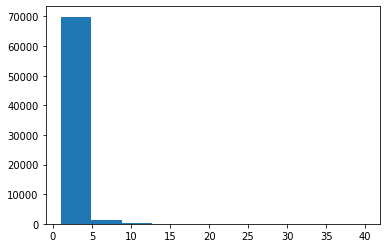

In [6]:
# let's drop records with missing values for gender 
data = data.loc[data['gender']!='Unknown/Invalid']

## Features to drop based on the Strack et al. paper

# 'Weight attribute was considered to be too sparse and it was not included in further analysis.'
data = data.drop(columns='weight')
# 'Payer code was removed since it had a high percentage of missing values and it was not considered relevant to the outcome.'
data = data.drop(columns='payer_code')
# 'Medical specialty attribute was maintained, adding the value “missing” in order to account for missing values.'
# For simplicity, we drop this column instead. 
data = data.drop(columns='medical_specialty')

#check the number of encounters per patient
plt.hist(data.groupby(['patient_nbr'])['encounter_id'].nunique())
# dropping records 
encounter_counts = data.groupby(['patient_nbr'])['encounter_id'].nunique()
data = data[data.patient_nbr.isin(encounter_counts[encounter_counts.values == 1].index)]

(array([    0.,     0.,     0.,     0.,     0., 54742.,     0.,     0.,
            0.,     0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

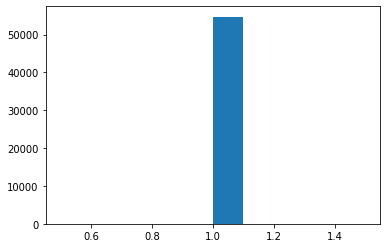

In [7]:
# check the distribution again.
plt.hist(data.groupby(['patient_nbr'])['encounter_id'].nunique())

_____

<br>


<font color='red'>**Action Item 1**: Analyse the data</font>
-------

Look at the data. Can you identify patterns. 
Remember, we will focus on predicting readmission.
In your submission you should describe what type of analyis you did and what patterns/correlations you identified.

Below is some sample code to get you started. You can modify/add to it.
<br>
<br>

------

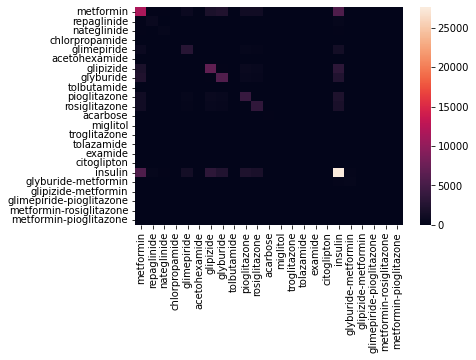

In [8]:
### Here you can add additional code to analyze the data
# Medication correlations -- GG/CK
import seaborn as sns

med_names = ['metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']
binarized_med_data = (data.loc[:, med_names] != 'No') * 1
correlation_matrix = binarized_med_data.apply(lambda row: np.outer(row, row), axis=1).sum()
sns.heatmap(correlation_matrix, annot=False, xticklabels = med_names, yticklabels = med_names)
plt.show()

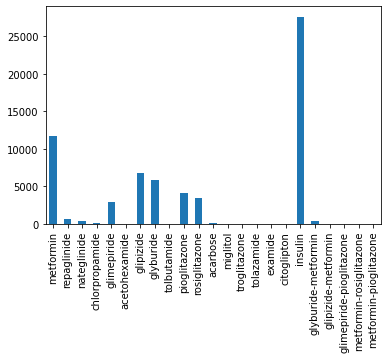

In [9]:
# Medication Prescription Rates -- GG/CK
med_freq = binarized_med_data.sum()
med_freq.plot.bar()

In [10]:
# Get a summary of the dataset with pandas.  
data.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,5.474200e+04,5.474200e+04,54742.000000,54742.000000,54742.000000,54742.000000,54742.000000,54742.000000,54742.000000,54742.000000,54742.000000,54742.000000,54742.000000
mean,1.614251e+08,5.585997e+07,2.119360,3.469676,5.629955,4.218936,43.382302,1.466223,15.629224,0.266852,0.090534,0.171733,7.183351
std,1.045316e+08,4.011112e+07,1.527472,5.080940,4.195691,2.936630,20.005624,1.771965,8.419023,1.027293,0.493677,0.591503,2.022203
min,1.252200e+04,3.780000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.251844e+07,2.334330e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.446917e+08,5.113054e+07,1.000000,1.000000,7.000000,3.000000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000
75%,2.267177e+08,8.783425e+07,3.000000,3.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,0.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,121.000000,6.000000,81.000000,36.000000,42.000000,12.000000,16.000000


Text(0, 0.5, 'counts')

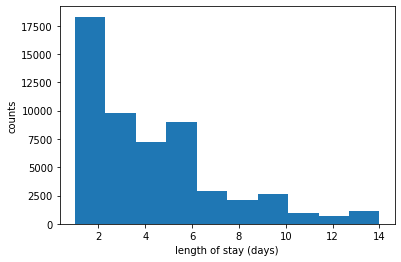

In [11]:
# Analyze length of stay
plt.hist(data['time_in_hospital']) 
plt.xlabel('length of stay (days)')
plt.ylabel('counts')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f58810b92e0>,
      dtype=object)

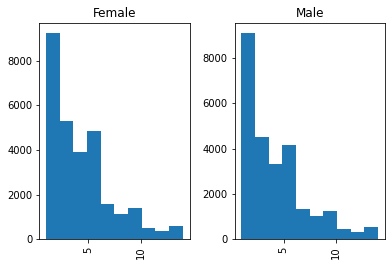

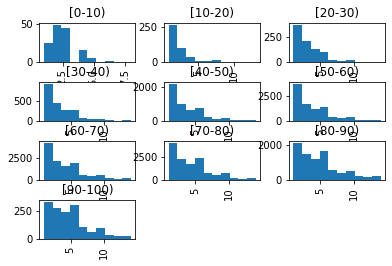

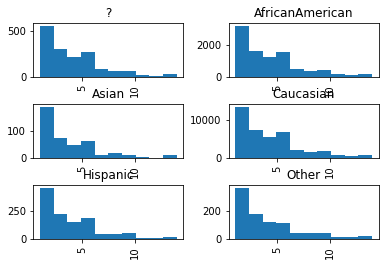

In [12]:
# Frequency of time in hospital by various groupings
#separate plots
data['time_in_hospital'].hist(by=data['gender'])
data['time_in_hospital'].hist(by=data['age'])
data['time_in_hospital'].hist(by=data['race'])


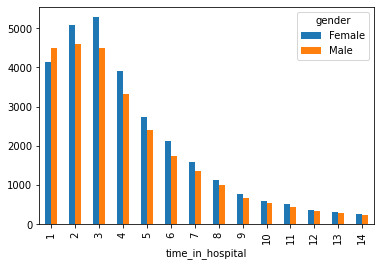

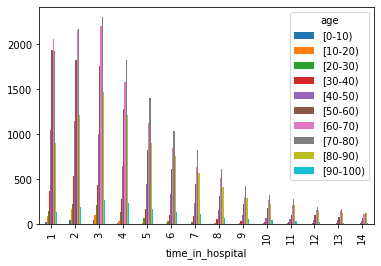

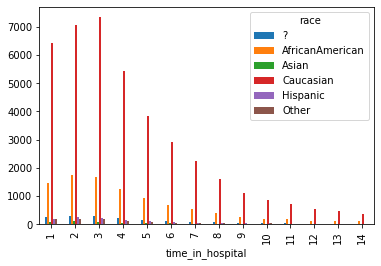

In [13]:
data.groupby('gender').time_in_hospital.value_counts().unstack(0).plot.bar()
data.groupby('age').time_in_hospital.value_counts().unstack(0).plot.bar()
data.groupby('race').time_in_hospital.value_counts().unstack(0).plot.bar()
# Note that this is the count, not the frequency. The histograms above show you the frequencies

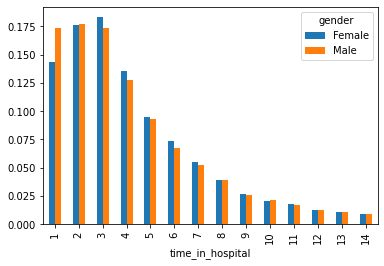

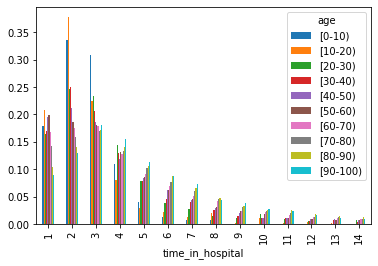

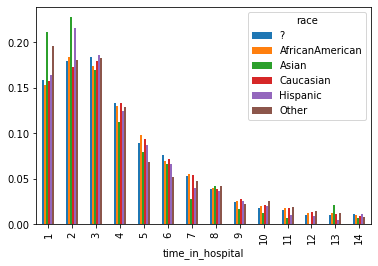

In [14]:
# Frequency of time in hospital by various groupings - same plot
data.groupby('gender').time_in_hospital.value_counts(normalize=True).unstack(0).plot.bar()
data.groupby('age').time_in_hospital.value_counts(normalize=True).unstack(0).plot.bar()
data.groupby('race').time_in_hospital.value_counts(normalize=True).unstack(0).plot.bar()

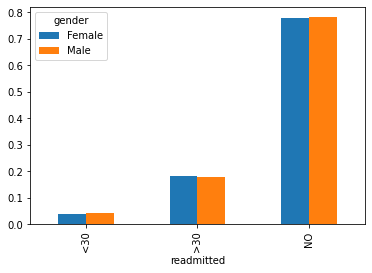

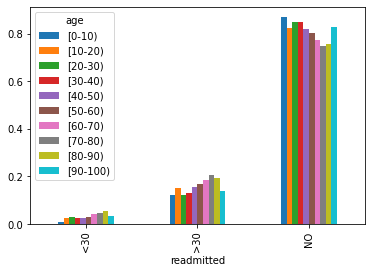

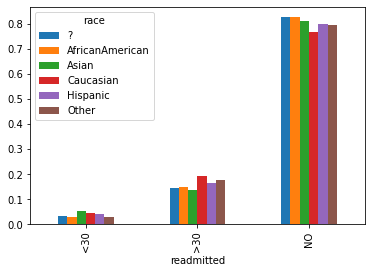

In [15]:
# Frequency of readmission  by various groupings - same plot
data.groupby('gender').readmitted.value_counts(normalize=True).unstack(0).plot.bar()
data.groupby('age').readmitted.value_counts(normalize=True).unstack(0).plot.bar()
data.groupby('race').readmitted.value_counts(normalize=True).unstack(0).plot.bar()

--------
--------

2.Train and Evaluate a Prediction Model
====

We will use the **sklearn.pipeline.Pipeline** to perform feature engineering and to train a classifier. For the purpose of this assignment, you do not need to know how to train the classifier; we are providing you with the code.

###**We are creating a  model to predict if a patient will be readmitted**###

**scikit-learn** or **sklearn** is a python module consisting of simple and efficient tools for predictive data analysis (preprocessing, feature selection, dimensionality reduction, regression, classification, clustering, et cetera).

**sklearn.pipeline.Pipeline** object takes a list of **transforms** and a final **estimator** and applies them sequentially on data.
- The possible transforms are preprocessing (e.g., MinMaxScaler, OneHotEncoder), missing value imputation (e.g., KNNImputer, SimpleImputer), dimensionality reduction (e.g., PCA), label encoding (e.g., LabelBinarizer), etc. Any transformers in the pipeline must implement fit and transform methods. For a more complete list, see: https://scikit-learn.org/stable/data_transforms.html

- The final part of the pipeline, the estimator, needs to implement a fit function at the least. The estimators can be classifiers, regressors, etc. For a more complete list, see: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

The purpose of setting up a pipeline is to allow the different transforms and estimator to be cross-validated together when setting their parameters. It also allows for the application of a pre-configured pipeline on new raw data. The different steps of the pipeline and their parameters can be accessed using their 'names'.

In [16]:
#Prepare the target variable Y: is a patient readmitted
'''
Target variable, readmitted, is binarized as below: 
  =1:  “readmitted” if the patient was readmitted within 30 days of discharge or 
  =0:   “otherwise” which covers both readmission after 30 days and no readmission at all. 
''' 
Y = (data['readmitted']=='<30').astype('int')
print(f'Readmitted rate within 30 days of discharge in the dataset={sum(Y==1)/len(Y)*100:1.3f}%')

Readmitted rate within 30 days of discharge in the dataset=3.957%


In [17]:
#Define Sensitive and control variables including demographics, severity and type of the disease, and type of admission.
sensitive_control_features = ['race', 'gender', 'age', 
          'admission_type', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
          ]
A = data[sensitive_control_features]
# Remove from the data the target and identifying features (encounter_id, and patient_nbr), as well as the sensitive and control features
X_raw = data.drop(columns=['readmitted', 'encounter_id', 'patient_nbr'] + sensitive_control_features)

In [18]:
# Define the model
from sklearn.model_selection import train_test_split

#Denoting categorical variables in the data 
for col in ['max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
          'num_medications', 'number_outpatient', 'number_emergency',
          'number_inpatient', 'number_diagnoses',
          'diag_1', 'diag_2', 'diag_3',
       ]:

    X_raw[col] = X_raw[col].astype('category')

## Split the data between training (X_train) and test(X_test) data
(X_train, X_test, y_train, y_test, A_train, A_test) = train_test_split(
    X_raw, Y, A, test_size=0.5, random_state=10000, stratify=Y
)

# Ensure indices are aligned between X, y and A,
# after all the slicing and splitting of DataFrames
# and Series

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
A_train = A_train.reset_index(drop=True)
A_test = A_test.reset_index(drop=True)

In [19]:
## Train a classifier to predict if a patient will be admitted based on the non-sensitive non-control non-identifying features
## Name of the classifier is unmitigated_predictor

from sklearn.linear_model import LogisticRegression

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline

unmitigated_predictor = Pipeline(
    steps=[
           #feature engineering component 
        ("preprocessor", ColumnTransformer(transformers=[
                                              # we use selector to indentify features based on its data type
                                              # Normalize numerical features
                                               ("num", StandardScaler(), selector(dtype_exclude="category")), 
                                              # Encoding (transforming) categorical features to what understandable by the model
                                              ("cat", OneHotEncoder(handle_unknown="ignore"), selector(dtype_include="category")),
                                            ]
                                          )
        ),
        # model component
        ("classifier",
         LogisticRegression(penalty='l2', C=0.1, verbose=0, max_iter=1000, 
                            class_weight={0:1, 1:10}),
        ),
    ]
)

## Performance and fairness metrics of the Classifier (prediction model).

Sklearn compiles a set of metrics to assess the quality of the classifier. We will use the following, which we discussed in class:


* Sample size
* Selection rate, percentage of positive cases:  fraction of predicted labels matching the ‘good’ outcome
* Accuracy: $\frac{TP + TN}{P + N}$
* FNR - False Negative Rate, percentage among readmitted that were predicted not to be readmitted (patients that could have used extra attention but did not get it): $\frac{FN}{FN + TP}$
* FPR - False Positive Rate, percentage among not readmitted that were predicted to be readmitted ("unnecessarily getting extra attention" - these people take resources that the hospital could have given to patients in need): $\frac{FP}{FP + TN}$
* Average Precision: Summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight
  * Precision: number of patients that were readmitted among those who were predicted to be readmitted: $\frac{TP}{TP + FP}$. High precision relates to a low FPR. 
  * Recall: number of patients that were readmitted among those needed to be readmitted $\frac{TP}{TP + FN}$. High recall relates to a low FNR. 
  * To learn more about precision and recall, visit 
  https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
* ROC AUC score: Computes Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores. 
  * ROC curve is defined by FPR (x values) and TPR (y values). The purpose of the graph is to illustrate the trade-offs between TP and FP. 
  * To learn more about ROC curve, visit https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

In [20]:
import sklearn.metrics as skm

unmitigated_predictor.fit(X_train, y_train)
y_pred = unmitigated_predictor.predict(X_test)

# get the overall performance metrics of the classifer
print("accuracy:", skm.accuracy_score(y_test, y_pred))
print("AUC:", skm.roc_auc_score(y_test, y_pred))
print('precision:', skm.precision_score(y_test, y_pred))
print('recall:', skm.recall_score(y_test, y_pred))
print('average_precision:', skm.average_precision_score(y_test, y_pred))
fpr, fnr, thresholds = skm.det_curve(y_test, y_pred)
print('FPR:', fpr[1])
print('FNR:', fnr[1])

accuracy: 0.8979942274670272
AUC: 0.587898311845379
precision: 0.12072791833111407
recall: 0.25115420129270544
average_precision: 0.05995122416158056
FPR: 0.07535757760194765
FNR: 0.7488457987072945


_____

<br>


<font color='red'>**Action Item 2**: Analyse the performance metrics</font>
-------

Does the prediction perform well? 

<br>
<br>

-----


--------
--------

3.Calculate the Fairness Metrics
====


### Use **fairlearn.metrics.MetricFrame** class to inspect model's fairness

We know that there are sensitive features in our data, and we want to ensure that we’re not harming individuals due to membership in any of these groups. For this purpose, Fairlearn provides the fairlearn.metrics.MetricFrame class. 

The **fairlearn.metrics.MetricFrame** object requires a minimum of four arguments:

* The underlying metric function(s) to be evaluated
* The true values
* The predicted values
* The sensitive feature values

Metric functions must have a signature ''fn(y_true, y_pred)'', i.e., require only two arguments.

In [21]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate, false_negative_rate, false_positive_rate

import functools

def insensitive_roc_auc(y_true, y_score):
    #to handle subgroups with only one class.
    if sum(y_true)!=len(y_true) and sum(y_true)!=0:
        return skm.roc_auc_score(y_true, y_score)
    else:
        return np.nan

def samplesize(y_true, y_score):
    return len(y_true)

#Metrics 
metric_fns = {'samplesize': samplesize, 
              'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their label
              'FNR': false_negative_rate, 
              'FPR': false_positive_rate, 
              'accuracy': skm.accuracy_score,
              'average_precision': skm.average_precision_score,
              'roc_auc_score': insensitive_roc_auc 
              }

#Gender grouping
grouped_on_gender = MetricFrame(metrics=metric_fns,
                             y_true=y_test, y_pred=y_pred,
                             sensitive_features=A_test['gender'])



In [22]:
#We can inspect the overall values, and check they are as expected (same as computed above):
assert grouped_on_gender.overall['selection_rate'] == selection_rate(y_test, y_pred)
assert grouped_on_gender.overall['accuracy'] == skm.accuracy_score(y_test, y_pred)
print(grouped_on_gender.overall)

samplesize              27371
selection_rate       0.082313
FNR                  0.748846
FPR                  0.075358
accuracy             0.897994
average_precision    0.059951
roc_auc_score        0.587898
dtype: object


### Check Fairness by Subgroup###

In [23]:
# Gender
#grouped_on_gender = MetricFrame(metrics=metric_fns,
                           #  y_true=y_test, y_pred=y_pred,
                            # sensitive_features=A_test['gender'])   DEFINED ABOVE
grouped_on_gender.by_group

,samplesize,selection_rate,FNR,FPR,accuracy,average_precision,roc_auc_score
gender,,,,,,,
Female,14362,0.081256,0.746552,0.07401,0.89883,0.062074,0.589719
Male,13009,0.083481,0.751491,0.076843,0.897071,0.057661,0.585833


In [24]:
# Race
grouped_on_race = MetricFrame(metrics=metric_fns,
                             y_true=y_test, y_pred=y_pred,
                             sensitive_features=A_test['race'])
grouped_on_race.by_group

,samplesize,selection_rate,FNR,FPR,accuracy,average_precision,roc_auc_score
race,,,,,,,
?,858,0.043124,0.826087,0.039521,0.939394,0.040946,0.567196
AfricanAmerican,4845,0.066254,0.714286,0.060059,0.921981,0.053431,0.612827
Asian,230,0.052174,0.833333,0.045872,0.913043,0.071256,0.560398
Caucasian,20368,0.088276,0.751991,0.081071,0.889974,0.062523,0.583469
Hispanic,584,0.09589,0.666667,0.084381,0.888699,0.084393,0.624476
Other,486,0.059671,0.888889,0.0587,0.925926,0.020292,0.526205


In [25]:
# Age
grouped_on_age = MetricFrame(metrics=metric_fns,
                             y_true=y_test, y_pred=y_pred,
                             sensitive_features=A_test['age'])
grouped_on_age.by_group

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


,samplesize,selection_rate,FNR,FPR,accuracy,average_precision,roc_auc_score
age,,,,,,,
[0-10),65,0.0,0.0,0.0,1.0,NaN,NaN
[10-20),205,0.029268,1.0,0.029851,0.95122,0.019512,0.485075
[20-30),431,0.023202,0.733333,0.014423,0.960557,0.132189,0.626122
[30-40),1095,0.032877,0.73913,0.027985,0.957078,0.059003,0.616442
[40-50),2648,0.061934,0.741935,0.057231,0.926737,0.042549,0.600417
[50-60),4981,0.061233,0.77931,0.056452,0.922506,0.045841,0.582119
[60-70),6107,0.082692,0.780769,0.07662,0.893401,0.057985,0.571305
[70-80),6819,0.098695,0.728659,0.089971,0.879308,0.070932,0.590685
[80-90),4288,0.109608,0.722727,0.100541,0.867537,0.073067,0.588366


#### Quantifying Disparities 
**Fairlearn** provides several means of aggregating metrics across the subgroups, so that disparities can be readily quantified.

In [26]:
'''
The simplest of these aggregations is group_min(), which reports the minimum value 
seen for a subgroup for each underlying metric (as well as group_max()). 
This is useful if there is a mandate that “no subgroup should have an accuracy() of less than 0.8.” 
'''
grouped_on_race.group_min()

samplesize                230
selection_rate       0.043124
FNR                  0.666667
FPR                  0.039521
accuracy             0.888699
average_precision    0.020292
roc_auc_score        0.526205
dtype: object

In [27]:
'''
The difference between metrics achieved on subgroups can be quantified 
in terms of a difference between the subgroup with the highest value of the metric, and the subgroup with the lowest value.
'''
grouped_on_race.difference(method='between_groups')

samplesize              20138
selection_rate       0.052767
FNR                  0.222222
FPR                   0.04486
accuracy             0.050695
average_precision    0.064101
roc_auc_score        0.098271
dtype: object

In [28]:
'''
We can also evaluate the difference relative to the corresponding overall value of the metric. 
In this case we take the absolute value, so that the result is always positive:'
'''
grouped_on_race.difference(method='to_overall')

samplesize              27141
selection_rate        0.03919
FNR                  0.140043
FPR                  0.035837
accuracy               0.0414
average_precision    0.039659
roc_auc_score        0.061693
dtype: object


```
# This is formatted as code
```

#### Intersections of sensitive features
We can examine the intersections of sensitive features by passing multiple columns to the fairlearn.metrics.MetricFrame constructor:

In [29]:
grouped_on_race_and_sex = MetricFrame(metrics=metric_fns,
                             y_true=y_test, y_pred=y_pred,
                                      sensitive_features=A_test[['gender', 'age']])
grouped_on_race_and_sex.by_group

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


samplesize selection_rate       FNR       FPR  accuracy  \
gender age                                                                
Female [0-10)           37            0.0       0.0       0.0       1.0   
       [10-20)         115       0.043478       1.0  0.044643  0.930435   
       [20-30)         267       0.022472       0.8  0.015564  0.955056   
       [30-40)         663       0.027149  0.769231  0.023077  0.962293   
       [40-50)        1272       0.058176  0.666667   0.05153  0.933962   
       [50-60)        2327       0.058015  0.746835  0.051157  0.925226   
       [60-70)        2949       0.087148  0.758065  0.080354   0.89115   
       [70-80)        3652       0.095564      0.75  0.088303  0.881982   
       [80-90)        2575       0.106019  0.731884   0.09684  0.869126   
       [90-100)        505        0.09901  0.789474   0.09465  0.879208   
Male   [0-10)           28            0.0       0.0       0.0       1.0   
       [10-20)          90       0.011111       1.0  0.011236  0.977778   
       [20-30)         164        0.02439       0.6  0.012579  0.969512   
       [30-40)         432       0.041667       0.7  0.035545  0.949074   
       [40-50)        1376       0.065407    0.8125    0.0625  0.920058   
       [50-60)        2654       0.064054  0.818182  0.061051  0.920121   
       [60-70)        3158       0.078531  0.801471   0.07313  0.895503   
       [70-80)        3167       0.102305  0.707317  0.091908  0.876224   
       [80-90)        1713       0.115003  0.707317   0.10607  0.865149   
       [90-100)        227        0.14978  0.571429  0.140909  0.845815   

                average_precision roc_auc_score  
gender age                                       
Female [0-10)                 NaN           NaN  
       [10-20)           0.026087      0.477679  
       [20-30)           0.096629      0.592218  
       [30-40)           0.053544      0.603846  
       [40-50)           0.060768      0.640902  
       [50-60)            0.06286      0.601004  
       [60-70)           0.060117      0.580791  
       [70-80)            0.06305      0.580849  
       [80-90)           0.075561      0.585638  
       [90-100)          0.046545      0.557938  
Male   [0-10)                 NaN           NaN  
       [10-20)           0.011111      0.494382  
       [20-30)           0.218293      0.693711  
       [30-40)           0.066204      0.632227  
       [40-50)           0.031395        0.5625  
       [50-60)           0.033181      0.560384  
       [60-70)            0.05613        0.5627  
       [70-80)           0.079988      0.600387  
       [80-90)           0.069516      0.593307  
       [90-100)          0.055436      0.643831

In [30]:
grouped_on_race_and_sex = MetricFrame(metrics=metric_fns,
                             y_true=y_test, y_pred=y_pred,
                                      sensitive_features=A_test[['race', 'gender']])
grouped_on_race_and_sex.by_group

samplesize selection_rate       FNR       FPR  \
race            gender                                                 
?               Female        436       0.043578  0.923077  0.042553   
                Male          422       0.042654       0.7  0.036408   
AfricanAmerican Female       2919        0.06235  0.695122   0.05534   
                Male         1926        0.07217  0.745098    0.0672   
Asian           Female        116       0.051724       1.0  0.053571   
                Male          114       0.052632      0.75  0.037736   
Caucasian       Female      10332       0.088657  0.749455   0.08113   
                Male        10036       0.087884  0.754762  0.081011   
Hispanic        Female        316       0.094937     0.625      0.08   
                Male          268       0.097015  0.727273  0.089494   
Other           Female        243       0.057613       1.0  0.059072   
                Male          243       0.061728  0.666667  0.058333   

                        accuracy average_precision roc_auc_score  
race            gender                                            
?               Female  0.931193          0.031572      0.517185  
                Male    0.947867          0.066588      0.631796  
AfricanAmerican Female  0.926687          0.061406      0.624769  
                Male    0.914849           0.04357      0.593851  
Asian           Female  0.913793          0.034483      0.473214  
                Male    0.912281          0.135965      0.606132  
Caucasian       Female  0.889179          0.064749      0.584707  
                Male    0.890793          0.060225      0.582114  
Hispanic        Female  0.892405          0.106646        0.6475  
                Male    0.884328          0.061319      0.591617  
Other           Female  0.917695          0.024691      0.470464  
                Male    0.934156          0.030453        0.6375

#### Control Features
There is a further way we can slice up our data. We have features for the patients' *admission_type_id* (Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available). When making predictions for readmission, it is acceptable that patients who were admitted due to a specific reason this time to have higher rate of readmission. However, within each admission type, we do not want a disparity between gender. To handle such senario, we introduce the concept of **control features**.

Control features are introduced by the `control_features= argument` to the `fairlearn.metrics.MetricFrame` object:

In [31]:
cond_admissiontype = MetricFrame( metrics={'sample size': samplesize,
                          'selection_rate': selection_rate,  
                          'accuracy': skm.accuracy_score,
                          'FNR': false_negative_rate, 
                          'FPR': false_positive_rate,
                          'roc_auc_score': insensitive_roc_auc },
                            y_true=y_test, y_pred=y_pred,
                                sensitive_features=A_test[['gender']],
                                control_features=A_test['admission_type'])
#Note that we removed some metrics because some subgroups had N=0, which led to division by 0 error

In [32]:
'''
This has an immediate effect on the overall property. 
Instead of having one value for each metric, we now have a value for each unique value of the control feature:
'''
cond_admissiontype.overall

,sample size,selection_rate,accuracy,FNR,FPR,roc_auc_score
admission_type,,,,,,
Elective,5527,0.069839,0.914239,0.72,0.061949,0.609026
Emergency,13851,0.083099,0.896614,0.761639,0.076836,0.580762
NULL,1865,0.164075,0.805362,0.691275,0.151515,0.578605
Newborn,2,0.0,1.0,0.0,0.0,NaN
Not Available,1027,0.017527,0.971762,1.0,0.017717,0.491142
Not Mapped,139,0.071942,0.870504,1.0,0.076336,0.461832
Trauma Center,11,0.0,1.0,0.0,0.0,NaN
Urgent,4949,0.077187,0.903819,0.764045,0.071264,0.582346


In [33]:
cond_admissiontype.by_group

sample size selection_rate  accuracy       FNR  \
admission_type gender                                                  
Elective       Female        2881       0.066296  0.919472   0.70297   
               Male          2646       0.073696  0.908541  0.737374   
Emergency      Female        7411       0.084739  0.893807  0.760656   
               Male          6440       0.081211  0.899845  0.762931   
NULL           Female         927        0.16397  0.802589  0.701299   
               Male           938       0.164179  0.808102  0.680556   
Newborn        Female           1            0.0       1.0       0.0   
               Male             1            0.0       1.0       0.0   
Not Available  Female         545       0.012844  0.974312       1.0   
               Male           482       0.022822   0.96888       1.0   
Not Mapped     Female          82       0.085366  0.841463       1.0   
               Male            57       0.052632  0.912281       1.0   
Trauma Center  Female           4            0.0       1.0       0.0   
               Male             7            0.0       1.0       0.0   
Urgent         Female        2511       0.072481  0.910793      0.75   
               Male          2438       0.082034  0.896637  0.776596   

                            FPR roc_auc_score  
admission_type gender                          
Elective       Female  0.057914      0.619558  
               Male    0.066353      0.598137  
Emergency      Female  0.078103      0.580621  
               Male    0.075387      0.580841  
NULL           Female  0.151765      0.573468  
               Male     0.15127      0.584087  
Newborn        Female       0.0           NaN  
               Male         0.0           NaN  
Not Available  Female  0.013011      0.493494  
               Male    0.023013      0.488494  
Not Mapped     Female  0.092105      0.453947  
               Male    0.054545      0.472727  
Trauma Center  Female       0.0           NaN  
               Male         0.0           NaN  
Urgent         Female  0.066337      0.591831  
               Male    0.076365       0.57352

---------

In [34]:
### Here you can add additional analysis code to analyze Fairness

-----
<br>


<font color='red'>**Action Item 3**: Analyze the Group Fairness</font>
-------

Is the prediction fair for different groups? 
Are there any differences in the performance that stand out to you?
Any case of Simpson's paradox?

<br>
<br>

--------




--------
--------

4.Mitigate the Unfairness of the Classifier.
====

**Fairlearn** provide preprocessing, postprocessing, and reductions modules for unfairness mitigation. For this assignment we will look at the behavior of a postprocessing method.


##Mitigating Difference with Postprocessing
We attempt to mitigate the disparities in the classifier using the Fairlearn postprocessing algorithm ThresholdOptimizer. This algorithm finds a suitable threshold for the scores (class probabilities) produced by the model by optimizing the accuracy rate under the constraint that the equalized odds (with respect to the sensitive feature and the outcome) is zero, using the training data. Here we consider race as the sensitive feature.



In [35]:
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
postprocess_est = ThresholdOptimizer(
    estimator=unmitigated_predictor.named_steps['classifier'],
    constraints="false_negative_rate_parity",
    objective='balanced_accuracy_score',predict_method='predict'
    )

In [36]:
X_train_ = unmitigated_predictor.named_steps['preprocessor'].fit_transform(X_train)
X_test_ = unmitigated_predictor.named_steps['preprocessor'].transform(X_test)

In [37]:
postprocess_est.fit(X_train_.toarray(), y_train, 
                    sensitive_features=A_train['race'])
postprocess_preds = postprocess_est.predict(X_test_.toarray(),
                                            sensitive_features=A_test['race'])



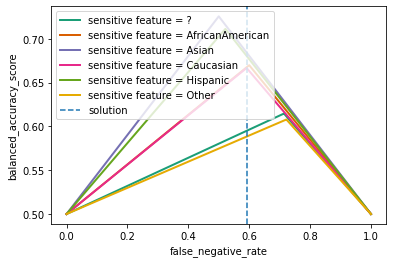

In [38]:
plot_threshold_optimizer(postprocess_est, ax=None, show_plot=True)

Let's further compare the mitigated and unmitigated models' performance.

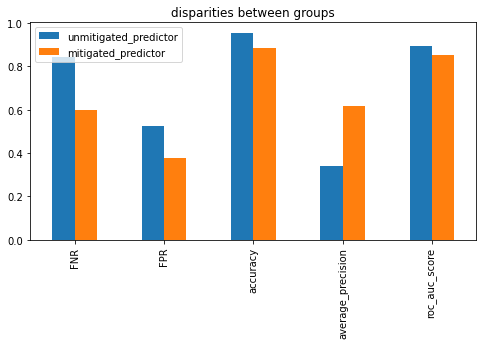

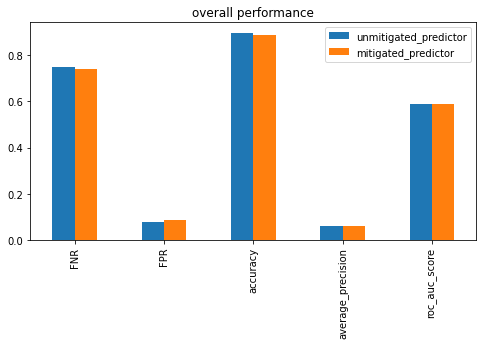

In [39]:
metric_fns = {'FNR': false_negative_rate, 
              'FPR': false_positive_rate, 
              'accuracy': skm.accuracy_score,
              'average_precision': skm.average_precision_score,
              'roc_auc_score': insensitive_roc_auc 
              }

modelnames, accuracies, disparities = [], [], []


#get performance for the unmitigated_predictor 
accuracy_metric_frame = MetricFrame(metrics=metric_fns,
                             y_true=y_test, y_pred=y_pred, 
                                    sensitive_features=A_test['race'])

accuracies.append(accuracy_metric_frame.overall)
disparities.append(accuracy_metric_frame.ratio(method='to_overall'))
modelnames.append('unmitigated_predictor')

#get performance for the mitigated predictor from GridSearch
accuracy_metric_frame = MetricFrame(metrics=metric_fns,
                             y_true=y_test, y_pred=postprocess_preds,
                                    sensitive_features=A_test['race'])

accuracies.append(accuracy_metric_frame.overall)
disparities.append(accuracy_metric_frame.ratio(method='to_overall'))
modelnames.append('mitigated_predictor')

#Plot the disparities between groups and overall accuracy metrics for the unmitigated and mitigated predictors below:
pd.DataFrame(disparities, index=modelnames).T.plot.bar(figsize=(8, 4), 
                                                       title='disparities between groups')
pd.DataFrame(accuracies, index=modelnames).T.plot.bar(figsize=(8, 4), 
                                                       title='overall performance')

In [40]:
# Mitigated values by Race
mitigated_grouped_on_race = MetricFrame(metrics=metric_fns,
                             y_true=y_test, y_pred=postprocess_preds,
                             sensitive_features=A_test['race'])
mitigated_grouped_on_race.by_group



,FNR,FPR,accuracy,average_precision,roc_auc_score
race,,,,,
?,0.608696,0.203593,0.785548,0.035992,0.593856
AfricanAmerican,0.691729,0.074278,0.908772,0.051314,0.616996
Asian,0.916667,0.03211,0.921739,0.058243,0.525612
Caucasian,0.753129,0.081174,0.889827,0.06228,0.582849
Hispanic,0.703704,0.075404,0.895548,0.079942,0.610446
Other,0.444444,0.178197,0.816872,0.039095,0.688679


In [41]:
# Unmitigated values by Race
grouped_on_race = MetricFrame(metrics=metric_fns,
                             y_true=y_test, y_pred=y_pred,
                             sensitive_features=A_test['race'])
grouped_on_race.by_group

,FNR,FPR,accuracy,average_precision,roc_auc_score
race,,,,,
?,0.826087,0.039521,0.939394,0.040946,0.567196
AfricanAmerican,0.714286,0.060059,0.921981,0.053431,0.612827
Asian,0.833333,0.045872,0.913043,0.071256,0.560398
Caucasian,0.751991,0.081071,0.889974,0.062523,0.583469
Hispanic,0.666667,0.084381,0.888699,0.084393,0.624476
Other,0.888889,0.0587,0.925926,0.020292,0.526205


-----
<br>


<font color='red'>**Action Item 4**: Analyze the Result of Fairness Mitigation</font>
-------

How do the unmitigated and mitigated predictors compare?

**Extra Credit:** Write the code and analysis to mitigate age unfairness.


<br>
<br>

--------


In [42]:
postprocess_est = ThresholdOptimizer(
    estimator=unmitigated_predictor.named_steps['classifier'],
    constraints="false_negative_rate_parity",
    objective='balanced_accuracy_score',predict_method='predict'
    )

In [43]:
X_train_ = unmitigated_predictor.named_steps['preprocessor'].fit_transform(X_train)
X_test_ = unmitigated_predictor.named_steps['preprocessor'].transform(X_test)

In [44]:
postprocess_est.fit(X_train_.toarray(), y_train, 
                    sensitive_features=A_train['age'])
postprocess_preds = postprocess_est.predict(X_test_.toarray(),
                                            sensitive_features=A_test['age'])



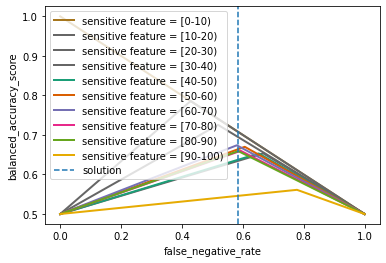

In [45]:
plot_threshold_optimizer(postprocess_est, ax=None, show_plot=True)

Let's further compare the mitigated and unmitigated models' performance.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


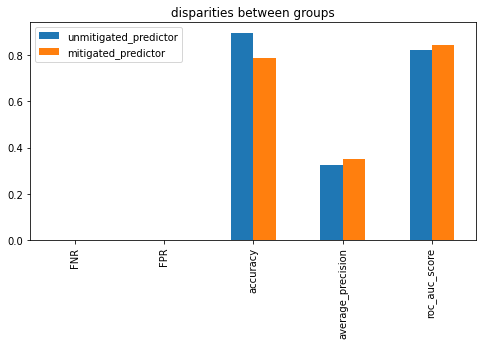

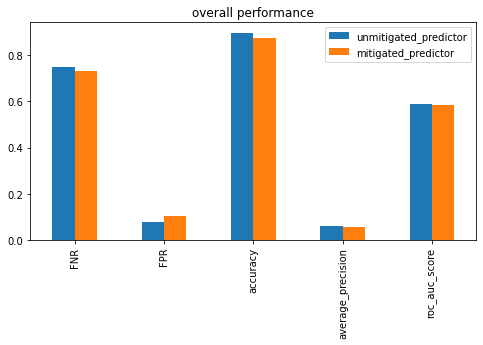

In [46]:
metric_fns = {'FNR': false_negative_rate, 
              'FPR': false_positive_rate, 
              'accuracy': skm.accuracy_score,
              'average_precision': skm.average_precision_score,
              'roc_auc_score': insensitive_roc_auc 
              }

modelnames, accuracies, disparities = [], [], []


#get performance for the unmitigated_predictor 
accuracy_metric_frame = MetricFrame(metrics=metric_fns,
                             y_true=y_test, y_pred=y_pred, 
                                    sensitive_features=A_test['age'])

accuracies.append(accuracy_metric_frame.overall)
disparities.append(accuracy_metric_frame.ratio(method='to_overall'))
modelnames.append('unmitigated_predictor')

#get performance for the mitigated predictor from GridSearch
accuracy_metric_frame = MetricFrame(metrics=metric_fns,
                             y_true=y_test, y_pred=postprocess_preds,
                                    sensitive_features=A_test['age'])

accuracies.append(accuracy_metric_frame.overall)
disparities.append(accuracy_metric_frame.ratio(method='to_overall'))
modelnames.append('mitigated_predictor')

#Plot the disparities between groups and overall accuracy metrics for the unmitigated and mitigated predictors below:
pd.DataFrame(disparities, index=modelnames).T.plot.bar(figsize=(8, 4), 
                                                       title='disparities between groups')
pd.DataFrame(accuracies, index=modelnames).T.plot.bar(figsize=(8, 4), 
                                                       title='overall performance')

In [47]:
# Mitigated values by Age
mitigated_grouped_on_age = MetricFrame(metrics=metric_fns,
                             y_true=y_test, y_pred=postprocess_preds,
                             sensitive_features=A_test['age'])
mitigated_grouped_on_age.by_group



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


,FNR,FPR,accuracy,average_precision,roc_auc_score
age,,,,,
[0-10),0.0,0.0,1.0,NaN,NaN
[10-20),1.0,0.014925,0.965854,0.019512,0.492537
[20-30),0.666667,0.122596,0.858469,0.052964,0.605369
[30-40),0.826087,0.022388,0.960731,0.042196,0.575762
[40-50),0.693548,0.1628,0.824773,0.029472,0.571826
[50-60),0.758621,0.091191,0.88938,0.039832,0.575094
[60-70),0.784615,0.076449,0.893401,0.057383,0.569468
[70-80),0.707317,0.100293,0.870509,0.071636,0.596195
[80-90),0.722727,0.100541,0.867537,0.073067,0.588366


In [48]:
# Unmitigated values by Age
grouped_on_age = MetricFrame(metrics=metric_fns,
                             y_true=y_test, y_pred=y_pred,
                             sensitive_features=A_test['age'])
grouped_on_age.by_group

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


,FNR,FPR,accuracy,average_precision,roc_auc_score
age,,,,,
[0-10),0.0,0.0,1.0,NaN,NaN
[10-20),1.0,0.029851,0.95122,0.019512,0.485075
[20-30),0.733333,0.014423,0.960557,0.132189,0.626122
[30-40),0.73913,0.027985,0.957078,0.059003,0.616442
[40-50),0.741935,0.057231,0.926737,0.042549,0.600417
[50-60),0.77931,0.056452,0.922506,0.045841,0.582119
[60-70),0.780769,0.07662,0.893401,0.057985,0.571305
[70-80),0.728659,0.089971,0.879308,0.070932,0.590685
[80-90),0.722727,0.100541,0.867537,0.073067,0.588366
